## 1.2 Modelldesign
### Skapa en heatmap av korrelationer i datan.
Se om du hittar features som är starkt korrelerade, dvs betydligt skiljt från 0
med positiv tal eller features som är starkt negativt korrelerade. Detta är en
ledning för kommande uppgifter och är en del av att designa modellen, men skall
presenteras som del av data-analysen. Lägg till heatmap och resonera kring vad
den visar tillsammans med den tidigare data-analysen du gjort.

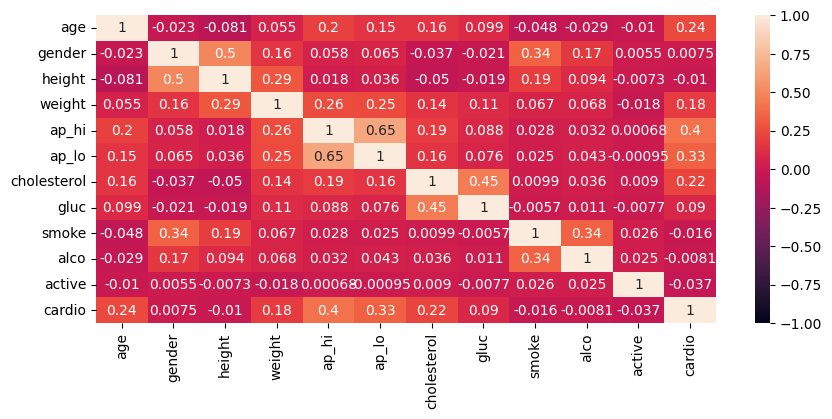

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
#Load and clean data
df = pd.read_csv("../Lab/data/cardio_train.csv",sep=";")
# Removing ID-column
df.drop(columns="id", inplace=True)
# Removing unreasonable values below 0 and above 300 for Systolic and Diastolic blood pressure.
df.drop(df[df["ap_hi"] < 0].index, inplace=True)
df.drop(df[df["ap_hi"] > 300].index, inplace=True)
df.drop(df[df["ap_lo"] < 0].index, inplace=True)
df.drop(df[df["ap_lo"] > 300].index, inplace=True)

# Kolla correlation
fig = plt.figure(figsize=(10, 4))
sns.heatmap(df.corr(),annot=True,vmin=-1,vmax=+1);

### 1.2.1 Feature Engineering
I detta avsnitt skall du dokumentera vad du gjorde i löpandet text. Ta inte med
misstag eller sidospår, utan bara vad som faktiskt ledde till det senare resultatet.
Skapa en feature för BMI (Body Mass Index), läs på om formeln på wikipedia.

#### BMI kolumn och kategorisk BMI

a) Släng de samples med orimliga BMIer och outliers. Notera att detta kan
vara svårt att avgöra i vilket range av BMIer som vi ska spara. Beskriv
hur du kommer fram till gränserna, med resonemang eller referens.

Här går det att läsa om BMI och olika rimliga värden på [BMI](https://www.aleris.se/overvikt/rakna-ut-ditt-bmi/). Eftersom kraftig undervikt för en kvinna är [under BMI 16](https://www.folkhalsomyndigheten.se/contentassets/c536d143d614486abf93b1261d2ec1b6/utveckling-bmi-sverige-1980-2022.pdf) har den nedre gränsen dragits vid 12 och den övre gränsen vid 60 då fetma grad 3 kan sägas vara över 40 [FHM](https://www.folkhalsomyndigheten.se/nyheter-och-press/nyhetsarkiv/2023/mars/fortsatt-okning-av-fetma-och-overvikt/), och det är fler som kan leva med en ett högt BMI än ett allt för lågt.

In [40]:
df["BMI"] = round(df["weight"] / ((df["height"]/100)**2), 2)
df.drop(df[df["BMI"] < 12].index, inplace=True)
df.drop(df[df["BMI"] > 60].index, inplace=True)

b) Skapa en kategorisk BMI-feature med kategorierna: normal range, overweight, obese (class I), obese (class II), obese (class III).

In [41]:
import numpy as np
# Define the conditions and categories for BMI classification
conditions = [
    (df['BMI'] < 25),
    (df['BMI'] >= 25) & (df['BMI'] < 30),
    (df['BMI'] >= 30) & (df['BMI'] < 35),
    (df['BMI'] >= 35) & (df['BMI'] < 40),
    (df['BMI'] >= 40)
]

categories = ['Normal range', 'Overweight', 'Obese (Class I)', 'Obese (Class II)', 'Obese (Class III)']

# Create a new feature 'BMI_category' based on the conditions
df['BMI_category'] = np.select(conditions, categories, default='Unknown')
# Convert 'BMI_category' to categorical feature
df['BMI_category'] = df['BMI_category'].astype('category')

df["BMI_category"].value_counts()

BMI_category
Normal range         26052
Overweight           24832
Obese (Class I)      12022
Obese (Class II)      4262
Obese (Class III)     1761
Name: count, dtype: int64

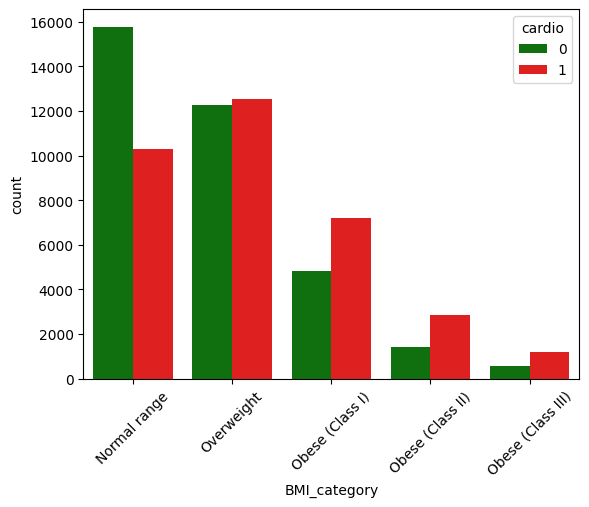

C:\Users\glajusj\AppData\Local\Temp\ipykernel_12028\2314114758.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('BMI_category')


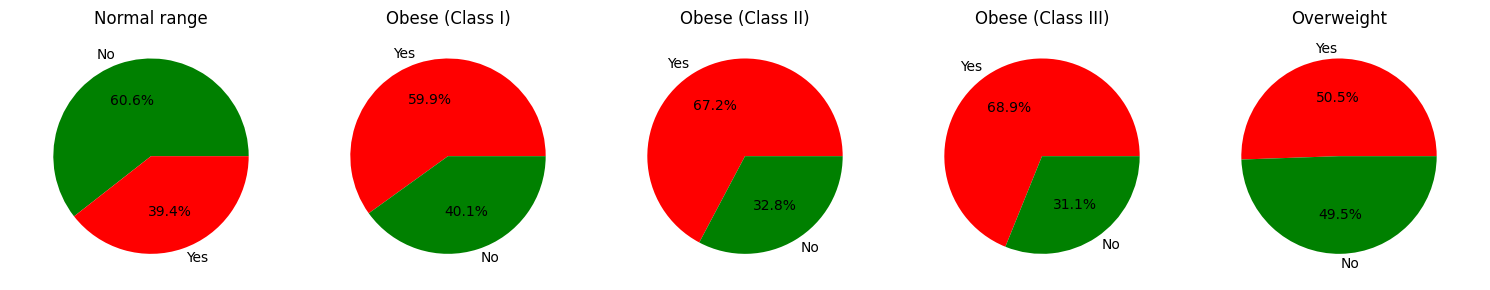

In [42]:
# Define colors for "Yes" and "No"
colors = {'No': 'green','Yes': 'red'}

# Plot countplot with specified palette
sns.countplot(x=df["BMI_category"], 
              hue=df["cardio"], 
              order=['Normal range', 'Overweight', 'Obese (Class I)', 'Obese (Class II)', 'Obese (Class III)'],
              palette=colors.values()  # Set palette to specify colors
            )
# Rotate x-axis labels at a 45-degree angle
plt.xticks(rotation=45)

# Show the plot
plt.show();

# Create a single figure with 5 subplots arranged in a 1x5 grid
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# Group the DataFrame by 'BMI_category' with the desired order
grouped = df.groupby('BMI_category')

# Iterate through each BMI category and create a pie plot
for i, (category, data) in enumerate(grouped):
    # Count the occurrences of cardio values (0|1)
    cardio_counts = data['cardio'].value_counts()
    
    # Calculate the percentages
    percentages = cardio_counts / cardio_counts.sum() * 100
    
    # Create a pie plot in the i-th subplot with specified colors
    axs[i].pie(percentages, labels=cardio_counts.index.map({0: 'No', 1: 'Yes'}), autopct='%1.1f%%', colors=[colors[val] for val in cardio_counts.index.map({0: 'No', 1: 'Yes'})])
    axs[i].set_title(f'{category}')
    axs[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('BMI_category.png')
# Show the plot
plt.show();

Undersök om kategorin är relevant, dvs dess korrelationer. Uppdatera data-analysen om du hittar något intressant.

Från våra pie-plots kan vi se att BMI-kategori indikerar att desto högre BMI en person har ger en större sannolikhet att man drabbas av en hjärt- och kärlsjukdom.

#### Bloodpressure Category
Nedan har gjorts en kategori för blodtryck, orimliga värden har fjärnats och och ett högsta och lägsta tillåtna värde har specificerats. Kategorierna kommer här ifrån: https://www.healthline.com/health/high-blood-pressure-hypertension#definition. Datan har rensats från värden som ligger under 30 slag och över 240 slag i minuten både vad gäller högsta och lägsta tryck. Att finna rimliga värden i de nedre regionerna visade sig vara svårt, därför har ett godtyckligt värde vid 30 slag per minut valts, ett slag varannan sekund, mindre än detta torde inte vara rimligt.

In [43]:
df.drop(df[df["ap_hi"] < 30].index, inplace=True)
df.drop(df[df["ap_hi"] > 240].index, inplace=True) # Tidigare har värden över 300 rensats
df.drop(df[df["ap_lo"] < 30].index, inplace=True)
df.drop(df[df["ap_lo"] > 240].index, inplace=True) # Tidigare har värden över 300 rensats

# Definiera conditions och kategorier för blodtrycksklassifikation
conditions = [
    (df['ap_hi'] < 120) & (df['ap_lo'] < 80),
    (df['ap_hi'].between(120, 129)) & (df['ap_lo'] < 80),
    (df['ap_hi'].between(130, 139)) | (df['ap_lo'].between(80, 89)),
    (df['ap_hi'] >= 140) | (df['ap_lo'] >= 90),
    (df['ap_hi'] > 180) | (df['ap_lo'] > 120)
]

categories = ['Healthy', 'Elevated', 'Stage 1 Hypertension', 'Stage 2 Hypertension', 'Hypertensive Crisis']

# Create a new column 'bloodpressure' based on the conditions
df['bloodpressure'] = np.select(conditions, categories, default='Unknown')
# Convert 'BMI_category' to categorical feature
df['bloodpressure'] = df['bloodpressure'].astype('category')

df["bloodpressure"].value_counts()

bloodpressure
Stage 1 Hypertension    39737
Stage 2 Hypertension    16317
Healthy                  9549
Elevated                 3110
Name: count, dtype: int64

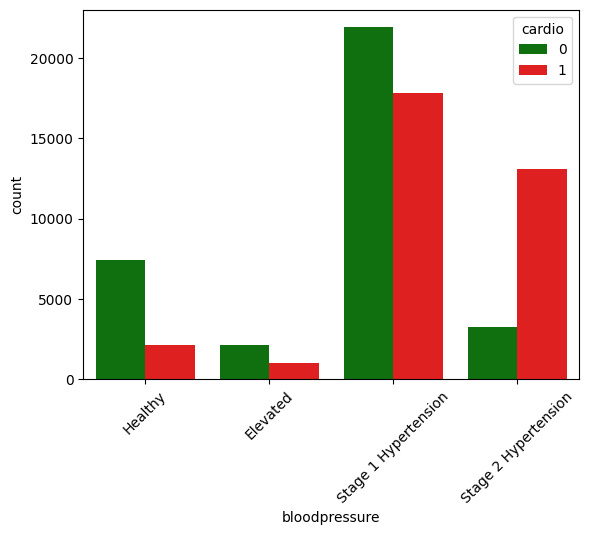

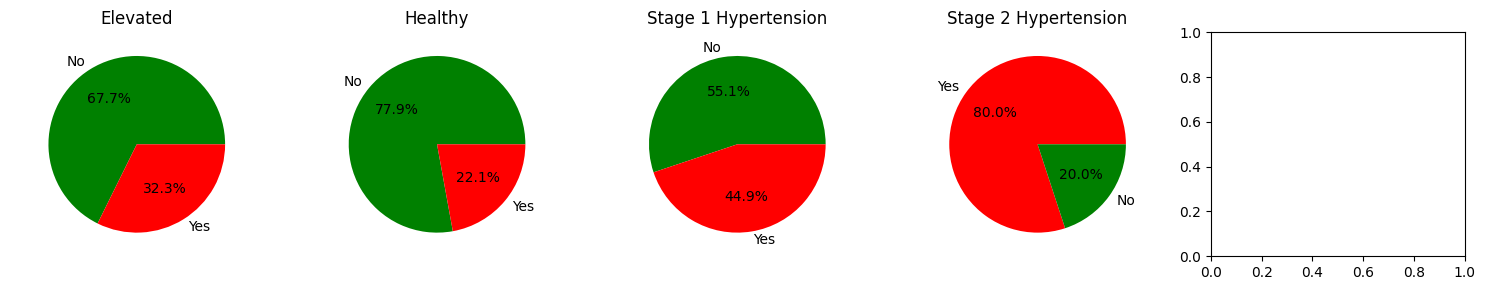

In [44]:
# Define colors for "Yes" and "No"
colors = {'No': 'green','Yes': 'red'}
sns.countplot(x=df["bloodpressure"], 
              hue=df["cardio"], 
              order=['Healthy', 'Elevated', 'Stage 1 Hypertension', 'Stage 2 Hypertension'], # removed , 'Hypertensive Crisis'
              palette=colors.values(),  # Set palette to specify colors
            )
# Rotate x-axis labels at a 45-degree angle
plt.xticks(rotation=45)

# Show the plot
plt.show();

# Create a single figure with 5 subplots arranged in a 1x5 grid
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

# Group the DataFrame by 'BMI_category'
grouped = df.groupby("bloodpressure", observed=True)

# Iterate through each BMI category and create a pie plot
for i, (category, data) in enumerate(grouped):
    # Count the occurrences of cardio values (0|1)
    cardio_counts = data['cardio'].value_counts()
    
    # Calculate the percentages
    percentages = cardio_counts / cardio_counts.sum() * 100
    
    # Create a pie plot in the i-th subplot
    axs[i].pie(percentages, 
               labels=cardio_counts.index.map({0: 'No', 1: 'Yes'}), 
               autopct='%1.1f%%', 
               colors=[colors[val] for val in cardio_counts.index.map({0: 'No', 1: 'Yes'})])
    axs[i].set_title(f'{category}')
    axs[i].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig('Bloodpressure_category.png')


# Show the plot
plt.show()

# Är ovan kategorier relevanta

Vi kan se i båda att desto högre BMI och blodtryck du har desto större risk att drabbas av en hjärt- och kärlsjukdom.   

#### 1.2.2 Skapa två dataset
Skapa en kopia av din dataframe. På ena dataframen: ta bort följande features: ap_hi, ap_lo, height, weight, BMI och gör one-hot encoding på BMI_category, bloodpressure samt gender. På andra dataframen: ta bort följande features: BMI_category, blodtryckskategori, height, weight och gör one-hot encoding på gender. Alltså en datamängd med kategorisk data tillagd och en med endast BMI tillagd. 
### 1.2.3 Utförande
Välj tre eller fler algoritmer. För varje algoritm: 
a) Använd gridsearchCV för att skala och hyperparameteroptimisera varje algoritm 
b) Utvärdera resulterande modell 
c) Kolla hyperparametrarna som ledde till bäst resultat 
d) Samla data om utfallet för senare presentation 
Upprepa detta för båda datamängderna. Välj datamängd och modell utifrån dina resultat. Dokumentera resultaten och motivera valen. 


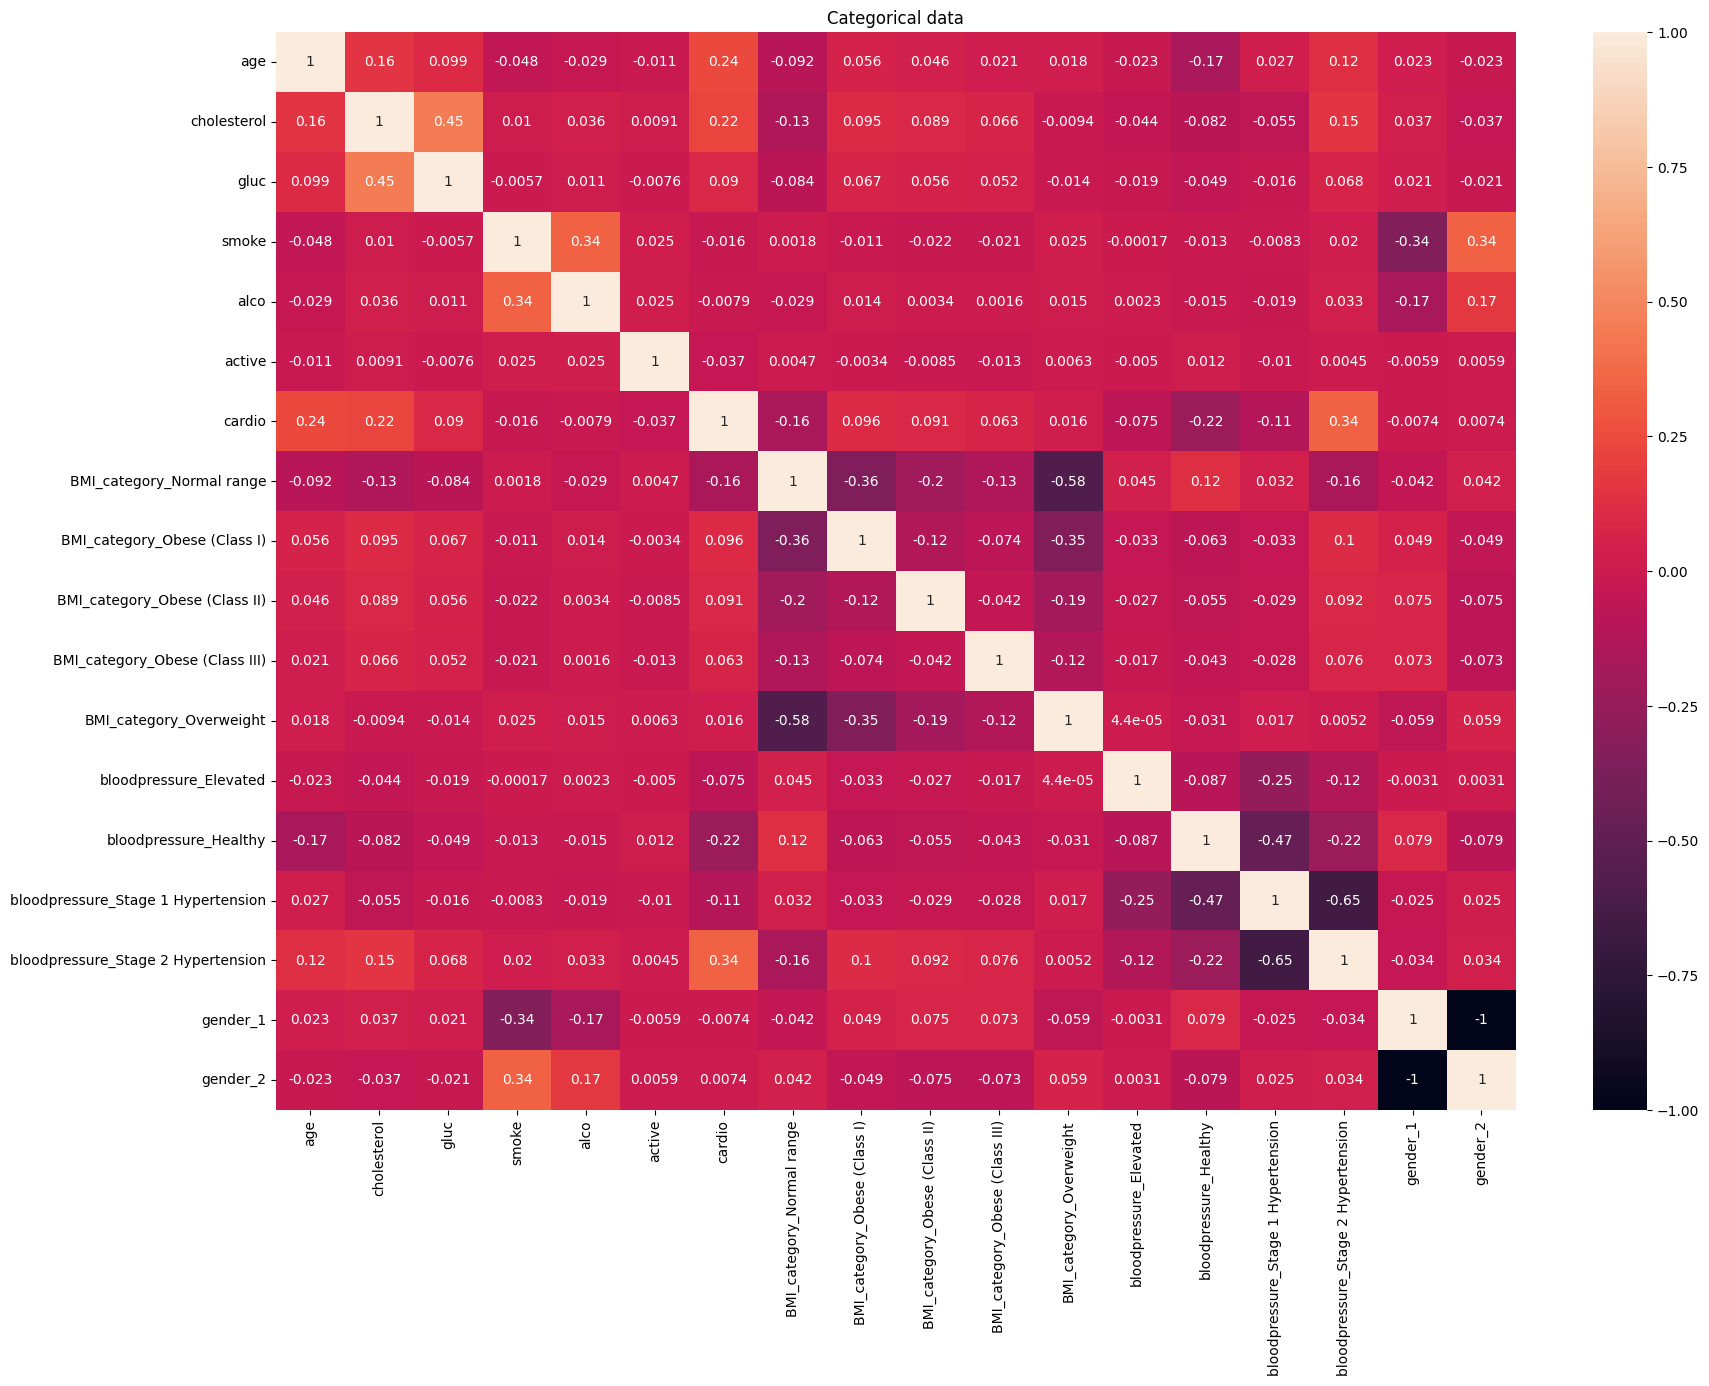

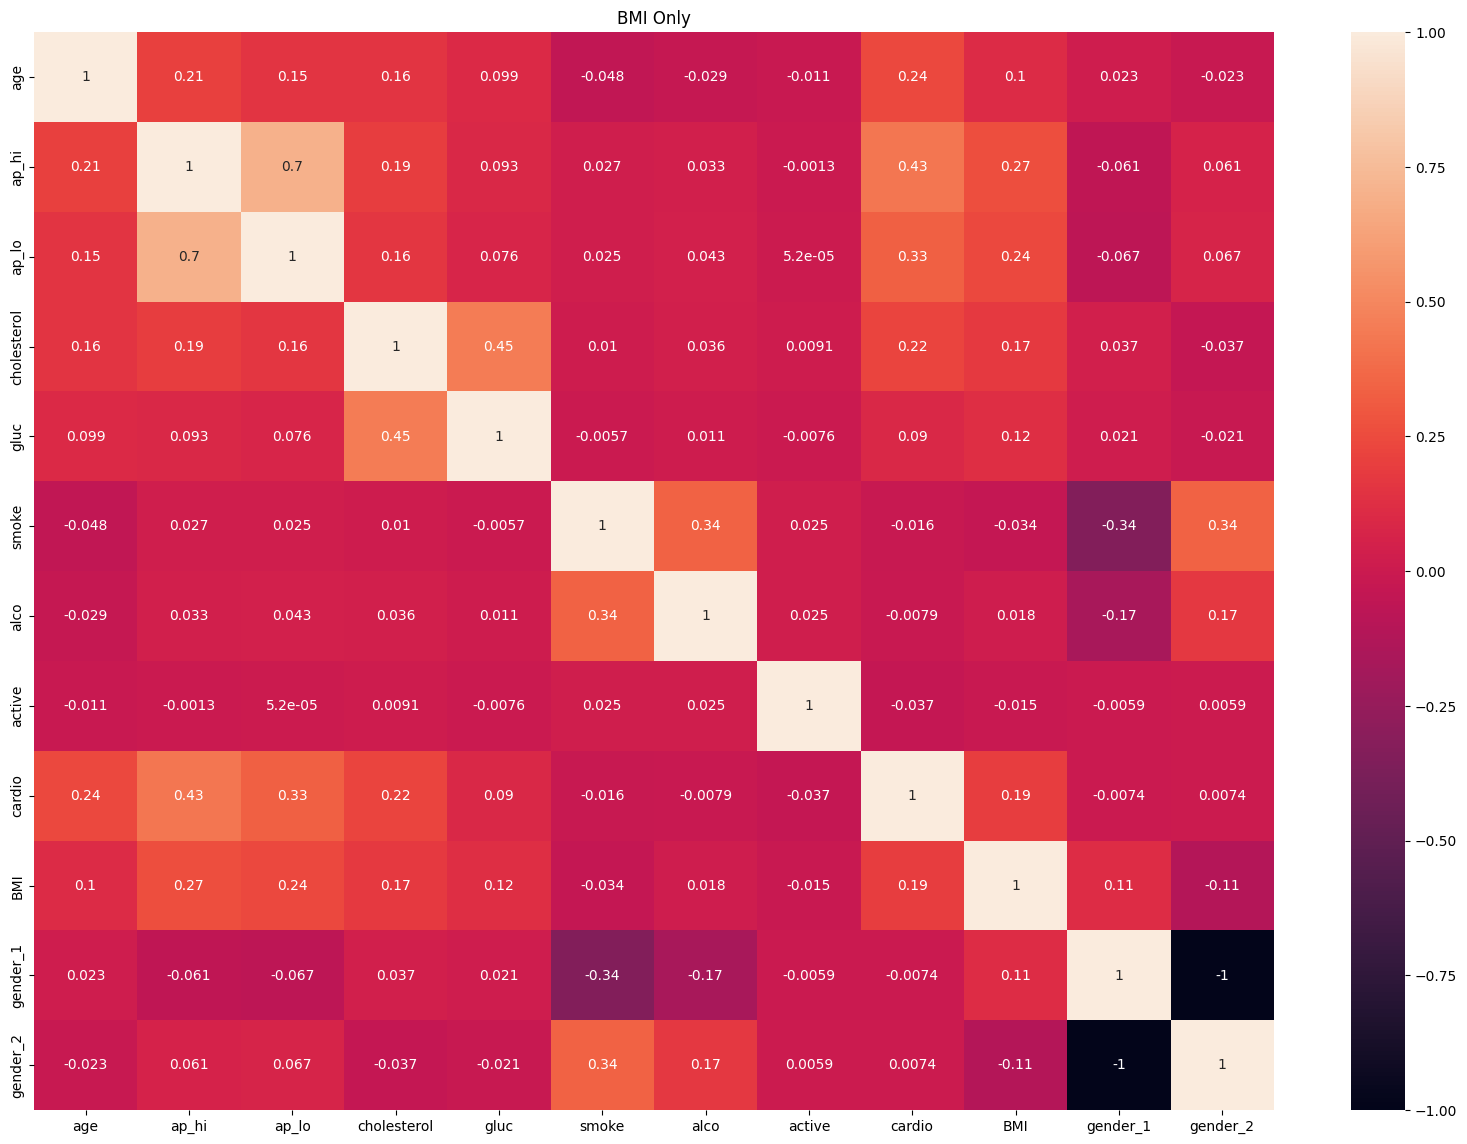

In [45]:
# Create a copy of the original DataFrame
df_copy1 = df.copy()
df_copy2 = df.copy()

# Remove specified features from the first DataFrame
features_to_remove_1 = ['ap_hi', 'ap_lo', 'height', 'weight', 'BMI']
df_copy1.drop(features_to_remove_1, axis=1, inplace=True)

# One-hot encode BMI category, blood pressure category, and gender
df_copy1 = pd.get_dummies(df_copy1, columns=['BMI_category', 'bloodpressure', 'gender'])

# Remove specified features from the second DataFrame
features_to_remove_2 = ['BMI_category', 'bloodpressure', 'height', 'weight']
df_copy2.drop(features_to_remove_2, axis=1, inplace=True)

# One-hot encode gender
df_copy2 = pd.get_dummies(df_copy2, columns=['gender'])

plt.figure(figsize=(20,14))
sns.heatmap(df_copy1.corr(numeric_only=True), annot=True,)
plt.title("Categorical data")
plt.show()
plt.figure(figsize=(20,14))
plt.title("BMI Only")
sns.heatmap(df_copy2.corr(numeric_only=True), annot=True)
plt.savefig("Final Dataset.png")
plt.show()

In [46]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import joblib

# Step 2: Model Training and Evaluation
datasets = {'Categorical Data': df_copy1, 'Only BMI': df_copy2}

algorithms = {
        'Random Forest': RandomForestClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'K-Nearest Neighbors': KNeighborsClassifier()
    }

param_grids = {
        'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10]},
        'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.05, 0.01]},
        'K-Nearest Neighbors': {'n_neighbors': [3, 5, 10]}
    }

scaler = StandardScaler()

for dataset_name, dataset in datasets.items():
    print(f"\nWorking on {dataset_name}:")
    
    X = dataset.drop(['cardio'], axis=1)
    y = dataset['cardio']

    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    for algo_name, algo in algorithms.items():
        print(f"\nPerforming {algo_name}...")
        param_grid = param_grids[algo_name]

        grid_search = GridSearchCV(algo, param_grid, cv=3, scoring='accuracy', return_train_score=True)
        grid_search.fit(X_train, y_train)

        # Print the best parameters found by GridSearchCV
        print(f"Best Parameters for {algo_name}:", grid_search.best_params_)

        y_pred = grid_search.predict(X_test)
        report = classification_report(y_test, y_pred)

        print(f"Evaluation Result for {algo_name} on {dataset_name}:\n{report}")
        
        # cm = confusion_matrix(y_test, y_pred)
        # plt.title(f'Confusion Matrix {dataset_name}, {algo_name}')
        # ConfusionMatrixDisplay(cm).plot()
        # plt.show()



Working on Categorical Data:

Performing Random Forest...
Best Parameters for Random Forest: {'max_depth': 10, 'n_estimators': 50}
Evaluation Result for Random Forest on Categorical Data:
              precision    recall  f1-score   support

           0       0.70      0.76      0.72     10545
           1       0.72      0.66      0.69     10069

    accuracy                           0.71     20614
   macro avg       0.71      0.71      0.71     20614
weighted avg       0.71      0.71      0.71     20614


Performing Gradient Boosting...
Best Parameters for Gradient Boosting: {'learning_rate': 0.1, 'n_estimators': 200}
Evaluation Result for Gradient Boosting on Categorical Data:
              precision    recall  f1-score   support

           0       0.70      0.76      0.73     10545
           1       0.72      0.66      0.69     10069

    accuracy                           0.71     20614
   macro avg       0.71      0.71      0.71     20614
weighted avg       0.71      0.71  

För varje kombination av algoritm och dataset inkluderar outputen följande:

**Precision**: Andelen sanna positiva förutsägelser bland alla positiva förutsägelser. Det indikerar noggrannheten hos positiva förutsägelser.
**Recall**: Andelen sanna positiva förutsägelser bland alla faktiska positiva instanser. Det indikerar modellens förmåga att hitta alla positiva instanser.
**F1-score**: Det harmoniska medelvärdet av precision och recall. Det ger en balans mellan precision och recall.
Support: Antalet faktiska förekomster av varje klass i testdatamängden.
**Accuracy**: Andelen korrekt klassificerade instanser bland alla instanser.

Från ovanstående noteras att de bästa förutsägelserna gjordes med Radom Forest och Gradient Boosting på datasetet "Only BMI". Det fick högst noggrannhet och hittade flest positiva förutsägelser. Eftersom det är viktigare att hitta de positiva fallen i detta fall väljer vi Random forest som hade aningen högre precision i testet.

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib

# Steg 2: Välj 100 slumpmässiga rader för testning och spara dem i en CSV-fil och ta bort dem från tränningsdatan
test_samples = df_copy2.sample(n=100)
test_samples.to_csv('../Lab/data/test_samples.csv', index=False)

# Steg 1: Läs in valda datasetet
df = df_copy2

# Steg 3: Dela upp datasetet i tränings- och testuppsättningar (uteslut de 100 testexemplen)
train_data = df.drop(test_samples.index)

# Steg 4: Extrahera funktioner (features) och målvariabel (target)
X_train = train_data.drop('cardio', axis=1)
y_train = train_data['cardio']

# Steg 5: Skapa och träna modellen med bästa parametrar för Random Forest
best_params = {'max_depth': 10, 'n_estimators': 200} # Enligt GridSearch
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train, y_train)

# Steg 6: Spara modellen som en .pkl-fil med joblib.dump()
joblib.dump(rf_model, 'trained_model.pkl', compress=3)

['trained_model.pkl']

In [48]:
test_samples.index

Index([33547, 26845, 18837, 47152, 29773, 48937, 26681, 20655, 56562, 13688,
       20079, 29713, 25995, 20875, 15386, 51949, 52419, 17002, 34095, 59659,
       25093,  1316, 28875, 55842, 32066, 51021, 29776, 66144, 56560, 13765,
       28224, 22482,  3001, 56197, 37768, 65610,  6850, 38566, 40516, 67642,
       11464,  8090,  3922,  3232, 31986, 32425, 62880, 19512, 31981, 56293,
       53495,  3883, 63341, 68788, 45957,  3592, 17974, 60287, 12851,  4192,
       67839, 26155,  4492, 53574, 17234, 50737, 10788, 19711, 13316, 35429,
       15933, 20961, 66343, 16826, 27285, 14865, 22645, 48865, 49758, 49867,
       54799, 46435,  6136, 69952, 61760, 40293,  9134,  5790, 25441, 35489,
        7046, 36727, 62879, 18074, 21787, 10103, 30255, 68915,  4332, 22918],
      dtype='int64')